In [217]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
font = {'family' : 'nomal', 'weight' : 'normal', 'size'   : 14}
mpl.rc('font', **font)
BASISSET='sto3g'
#BASISSET='cc-pVDZ'

# read cached data
df = pd.read_pickle('../data-tmp/n6-%s.pkl.gz' % BASISSET)
grid = pd.read_pickle('../data-tmp/grids/N6.pkl')
coordinates, points, weights = grid.coordinates.values[0], grid.points.values[0], grid.weights.values[0]

In [218]:
# integrate densities
def integrate():
    # cache distances
    ds = []
    for atom in range(len(coordinates)):
        ds.append(np.linalg.norm(points - coordinates[atom], axis=1))

    # calculate integral values
    res = []
    for name, group in df.groupby('target'):
        rhotilde = np.trapz(group.density.values, group.mixing.values, axis=0)
        contributions = []
        for atom in range(len(coordinates)):
            contributions.append(-np.sum(weights * rhotilde / ds[atom]))
        res.append({'target': name, 'contributions': np.array(contributions)})
    return pd.DataFrame(res)
integrated = integrate()

In [219]:
# decompose groups: return energies per component (NNH, HNH, CCH, HCH, BBH, HBH, NH, BH, CH)
def decompose():
    groups = np.vstack((np.arange(6), np.roll(np.arange(6, 12), 1))).T
    labellookup = {-2: 'BH', -1: 'CH', 0: 'NH'}
    groupres = []
    siteres = []
    for idx, row in integrated.iterrows():
        numtarget =  np.array(list(map(int, row.target.split('-'))))
        dZ = numtarget - np.array([7]*6 + [0]*6)
        assert (sum(dZ) == 0)
        baseenergy = df.query("mixing == 0 & target == @row.target").energy.values[0]
        baseenergy -= sum([compute_nucnuc((7,7,7,7,7,7,0,0,0,0,0,0), _) for _ in range(6)])
        baseenergy /= 6
        for group in groups:
            grouptype = labellookup[dZ[group[0]]]
            electronicenergy = dZ[group]*row.contributions[group] 
            electronicenergy[0] += baseenergy
            totalenergy = electronicenergy + np.array([compute_nucnuc(numtarget, _) for _ in group])
            
            groupres.append({'name': grouptype, 'target': row.target, 'energy': sum(electronicenergy), 'total': sum(totalenergy)})
            for atom in range(len(group)):
                label = grouptype[atom] + grouptype
                siteres.append({'name': label, 'target': row.target, 'energy': electronicenergy[atom], 'total': totalenergy[atom]})
    return pd.DataFrame(groupres), pd.DataFrame(siteres)
groupdata, sitedata = decompose()

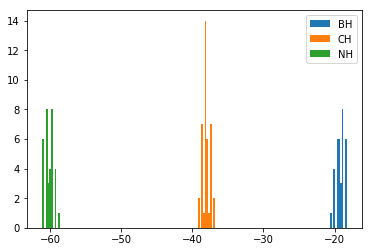

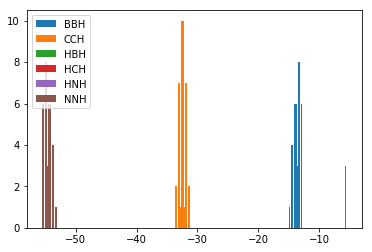

In [125]:
# plot component energies (bar plot?)
for name, group in groupdata.groupby('name'):
    plt.hist(group.total, label=name)
plt.legend()
plt.show()
for name, group in sitedata.groupby('name'):
    plt.hist(group.total, label=name)
plt.legend()

In [97]:
def compute_nucnuc(charges, siteid):
    ret = 0
    for site in range(len(coordinates)):
        if site == siteid:
            continue
        d = np.linalg.norm(coordinates[site] - coordinates[siteid])
        ret += charges[siteid] * charges[site] / d
    return ret/2


In [220]:
q = pd.merge(df.query("mixing == 1"), groupdata.groupby('target').sum().reset_index(), on='target')
residuals = (q.energy_x - q.total).values
np.average(residuals), np.sqrt(np.var(residuals))

(0.0006209348258039427, 0.0002503588749963043)

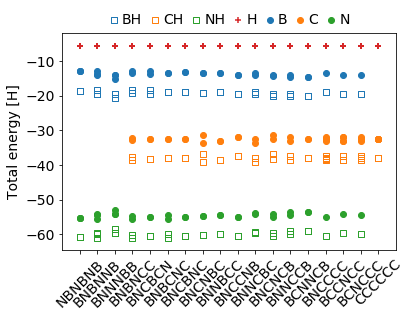

In [221]:
ordering = df.query("mixing == 1").sort_values('energy').target.values[::1]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
cgroups = 'BH CH NH'.split()

grouphandles = {}
for row, name in enumerate(ordering):
    group = groupdata.query('target == @name')
    for _, entry in group.iterrows():
        _ = plt.scatter(row, entry.total, color=colors[cgroups.index(entry['name'])], marker='s', facecolors='none')
        grouphandles[entry['name']] = _

row = 0
markers = {'HBH': '+', 'HCH': '+', 'HNH': '+', 'BBH': 'o', 'CCH': 'o', 'NNH': 'o', }
cgroups = 'B C N H'.split()
sitehandles = {}
for row, name in enumerate(ordering):
    group = sitedata.query('target == @name')
    for _, entry in group.iterrows():
        _ = plt.scatter(row, entry.total, marker=markers[entry['name']], color=colors[cgroups.index(entry['name'][0])])
        sitehandles[entry['name'][0]] = _

ax = plt.gca()
ax.set_xticks(list(range(len(ordering))))
ax.set_xticklabels([to_string(_) for _ in ordering])
ax.tick_params(axis='x', labelrotation=45)
plt.ylabel('Total energy [H]')

groupnames = 'BH CH NH'.split()
sitenames = 'H B C N'.split()
plt.legend(loc='upper center', ncol=7, bbox_to_anchor=(0.5, 1.15), labelspacing=0.05, handletextpad=0.2, columnspacing=0.5, handlelength=0.8, fancybox=False, frameon=False, handles=[grouphandles[_] for _ in groupnames] + [sitehandles[_] for _ in sitenames],labels=groupnames + sitenames)
plt.savefig('n6total.pdf', bbox_inches='tight')

In [174]:
def to_string(target):
    numtarget = np.array(list(map(int, target.split('-'))))[:6]
    return ''.join([{5:'B', 6:'C', 7:'N'}[_] for _ in numtarget])
    

array([ 4.40965146e-04,  2.33587169e-03, -2.01452513e-04, -2.24744219e-04,
       -3.01288743e-04, -8.60536157e-04, -2.15061995e-04, -3.79516408e-01,
        9.68607693e-04, -3.79081581e-01, -3.67230281e-04, -2.30811772e-04,
       -1.76404694e-04, -2.38668906e-04, -1.69277294e-04, -7.51323582e-04,
       -1.10729750e-03])